# Temporal Classification

A logistic regression analyzes the relationship between a binary target variable and its predictor variables to estimate the probability of the dependent variable taking the value 1. In the presence of temporal data where observations along time aren't independent, the errors of the model will be correlated through time and incorporating autoregressive features or lags can capture temporal dependencies and enhance the predictive power of logistic regression.

<br>NHITS's inputs are static exogenous $\mathbf{x}^{(s)}$, historic exogenous $\mathbf{x}^{(h)}_{[:t]}$, exogenous available at the time of the prediction $\mathbf{x}^{(f)}_{[:t+H]}$ and autorregresive features $\mathbf{y}_{[:t]}$, each of these inputs is further decomposed into categorical and continuous. The network uses a multi-quantile regression to model the following conditional probability:$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(h)}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

In this notebook we show how to fit NeuralForecast methods for binary sequences regression. We will:
- Installing NeuralForecast.
- Loading binary sequence data.
- Fit and predict temporal classifiers.
- Plot and evaluate predictions.

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Temporal_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
#%%capture
#!pip install neuralforecast

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, NHITS, LSTM
from neuralforecast.losses.pytorch import DistributionLoss, Accuracy

## 2. Loading Binary Sequence Data

The `core.NeuralForecast` class contains shared, `fit`, `predict` and other methods that take as inputs pandas DataFrames with columns `['unique_id', 'ds', 'y']`, where `unique_id` identifies individual time series from the dataset, `ds` is the date, and `y` is the target binary variable. 

In this motivation example we convert 8x8 digits images into 64-length sequences and define a classification problem, to identify when the pixels surpass certain threshold.
We declare a pandas dataframe in long format, to match NeuralForecast's inputs.

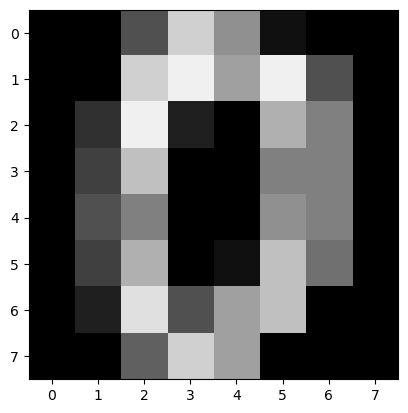

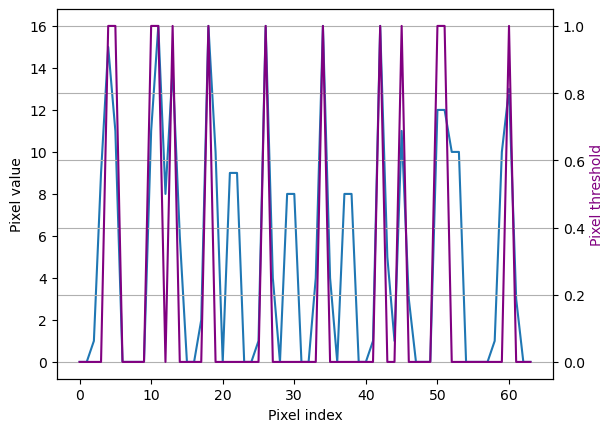

In [ ]:
digits = datasets.load_digits()
images = digits.images[:100]

plt.imshow(images[0,:,:], cmap=plt.cm.gray, 
           vmax=16, interpolation="nearest")

pixels = np.reshape(images, (len(images), 64))
ytarget = (pixels > 10) * 1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(pixels[10])
ax2.plot(ytarget[10], color='purple')
ax1.set_xlabel('Pixel index')
ax1.set_ylabel('Pixel value')
ax2.set_ylabel('Pixel threshold', color='purple')
plt.grid()
plt.show()

In [ ]:
# We flat the images and create an input dataframe
# with 'unique_id' series identifier and 'ds' time stamp identifier.
Y_df = pd.DataFrame.from_dict({
            'unique_id': np.repeat(np.arange(100), 64),
            'ds': np.tile(np.arange(64)+1910, 100),
            'y': ytarget.flatten(), 'pixels': pixels.flatten()})
Y_df

,unique_id,ds,y,pixels
0,0,1910,0,0.0
1,0,1911,0,0.0
2,0,1912,0,5.0
3,0,1913,1,13.0
4,0,1914,0,9.0
...,...,...,...,...
6395,99,1969,1,14.0
6396,99,1970,1,16.0
6397,99,1971,0,3.0
6398,99,1972,0,0.0


## 3. Fit and predict temporal classifiers

### Fit the models

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You can define the forecasting `horizon` (12 in this example), and modify the hyperparameters of the model. For example, for the `NHITS` we changed the default hidden size for both encoder and decoders.

See the `NHITS` and `MLP` [model documentation](https://nixtla.github.io/neuralforecast/models.mlp.html).

:::{.callout-warning}
For the moment Recurrent-based model family is not available to operate with Bernoulli distribution output.
This affects the following methods `LSTM`, `GRU`, `DilatedRNN`, and `TCN`. This feature is work in progress.
:::

In [ ]:
# %%capture
horizon = 12

# Try different hyperparmeters to improve accuracy.
models = [MLP(h=horizon,                           # Forecast horizon
              input_size=2 * horizon,              # Length of input sequence
              loss=DistributionLoss('Bernoulli'),  # Binary classification loss
              valid_loss=Accuracy(),               # Accuracy validation signal
              max_steps=500,                       # Number of steps to train
              scaler_type='standard',              # Type of scaler to normalize data
              hidden_size=64,                      # Defines the size of the hidden state of the LSTM
              #early_stop_patience_steps=2,         # Early stopping regularization patience
              val_check_steps=10,                  # Frequency of validation signal (affects early stopping)
              ),
          NHITS(h=horizon,                          # Forecast horizon
                input_size=2 * horizon,             # Length of input sequence
                loss=DistributionLoss('Bernoulli'), # Binary classification loss
                valid_loss=Accuracy(),              # Accuracy validation signal                
                max_steps=500,                      # Number of steps to train
                n_freq_downsample=[2, 1, 1],        # Downsampling factors for each stack output
                #early_stop_patience_steps=2,        # Early stopping regularization patience
                val_check_steps=10,                 # Frequency of validation signal (affects early stopping)
                )             
          ]
nf = NeuralForecast(models=models, freq='Y')
Y_hat_df = nf.cross_validation(df=Y_df, n_windows=1)

Global seed set to 1
Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.74it/s]


In [ ]:
# By default NeuralForecast produces forecast intervals
# In this case the lo-x and high-x levels represent the 
# low and high bounds of the prediction accumulating x% probability
Y_hat_df = Y_hat_df.reset_index(drop=True)
Y_hat_df

,unique_id,ds,cutoff,MLP,MLP-median,MLP-lo-90,MLP-lo-80,MLP-hi-80,MLP-hi-90,NHITS,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,y,pixels
0,0,1962,1961,0.190,0.0,0.0,0.0,1.0,1.0,0.422,0.0,0.0,0.0,1.0,1.0,0,10.0
1,0,1963,1961,0.754,1.0,0.0,0.0,1.0,1.0,0.955,1.0,1.0,1.0,1.0,1.0,1,12.0
2,0,1964,1961,0.035,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0,0.0
3,0,1965,1961,0.049,0.0,0.0,0.0,0.0,0.0,0.015,0.0,0.0,0.0,0.0,0.0,0,0.0
4,0,1966,1961,0.042,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,99,1969,1961,0.484,0.0,0.0,0.0,1.0,1.0,0.817,1.0,0.0,0.0,1.0,1.0,1,14.0
1196,99,1970,1961,0.587,1.0,0.0,0.0,1.0,1.0,0.495,0.0,0.0,0.0,1.0,1.0,1,16.0
1197,99,1971,1961,0.336,0.0,0.0,0.0,1.0,1.0,0.126,0.0,0.0,0.0,1.0,1.0,0,3.0
1198,99,1972,1961,0.046,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0,0.0


In [ ]:
# Define classification threshold for final predictions
# If (prob > threshold) -> 1
Y_hat_df['NHITS'] = (Y_hat_df['NHITS'] > 0.5) * 1
Y_hat_df['MLP'] = (Y_hat_df['MLP'] > 0.5) * 1
Y_hat_df

,unique_id,ds,cutoff,MLP,MLP-median,MLP-lo-90,MLP-lo-80,MLP-hi-80,MLP-hi-90,NHITS,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,y,pixels
0,0,1962,1961,0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0,1.0,1.0,0,10.0
1,0,1963,1961,1,1.0,0.0,0.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1,12.0
2,0,1964,1961,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,0,1965,1961,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,0,1966,1961,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,99,1969,1961,0,0.0,0.0,0.0,1.0,1.0,1,1.0,0.0,0.0,1.0,1.0,1,14.0
1196,99,1970,1961,1,1.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0,1.0,1.0,1,16.0
1197,99,1971,1961,0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0,1.0,1.0,0,3.0
1198,99,1972,1961,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0


## 4. Plot and Evaluate Predictions

Finally, we plot the forecasts of both models againts the real values.
And evaluate the accuracy of the `MLP` and `NHITS` temporal classifiers.

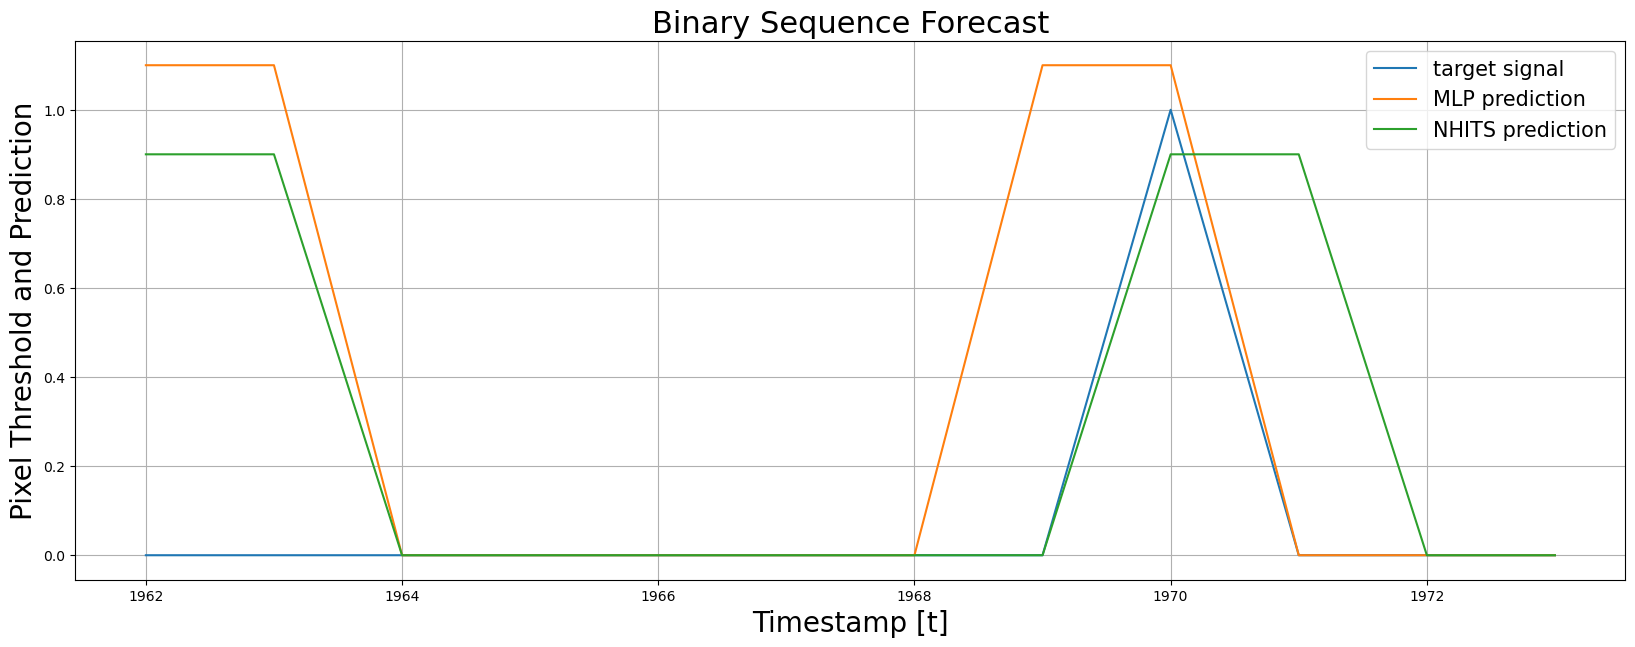

In [ ]:
plot_df = Y_hat_df[Y_hat_df.unique_id==10]

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plt.plot(plot_df.ds, plot_df.y, label='target signal')
plt.plot(plot_df.ds, plot_df['MLP'] * 1.1, label='MLP prediction')
plt.plot(plot_df.ds, plot_df['NHITS'] * .9, label='NHITS prediction')
ax.set_title('Binary Sequence Forecast', fontsize=22)
ax.set_ylabel('Pixel Threshold and Prediction', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

mlp_acc = accuracy(y=Y_hat_df['y'], y_hat=Y_hat_df['MLP'])
nhits_acc = accuracy(y=Y_hat_df['y'], y_hat=Y_hat_df['NHITS'])

print(f'MLP Accuracy: {mlp_acc:.1%}')
print(f'NHITS Accuracy: {nhits_acc:.1%}')

MLP Accuracy: 77.7%
NHITS Accuracy: 78.1%


## References

- [Cox D. R. (1958). “The Regression Analysis of Binary Sequences.” Journal of the Royal Statistical Society B, 20(2), 215–242.](https://arxiv.org/abs/2201.12886)
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2023). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)